In [1]:
import argparse
import logging
import math
import os
import random
import shutil
import yaml
import shutil
import json
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import wandb
import torch.nn.functional as F
from dataset import OneActorDataset

/workspace/oa_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

import pickle

from projector import Projector

torch.autograd.set_detect_anomaly(True)


/workspace/Diploma/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/workspace/Diploma/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
from datetime import datetime
import numpy as np

In [4]:
torch.autograd.set_detect_anomaly(True)

In [5]:
logger = get_logger(__name__)


def init_wanddb(config=None):
    wandb.init(project="OneActor", entity="eadishcheva")
    run = wandb.init(
        # Set the wandb entity where your project will be logged (generally your team name).
        entity="eadishcheva",
        # Set the wandb project where this run will be logged.
        project="OneActor",
        # Track hyperparameters and run metadata.
        config=config,
    )
    return run


In [6]:
def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str = None, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")
    
def save_progress(projector, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_projector = (
        accelerator.unwrap_model(projector)
    )

    torch.save(learned_projector, save_path)


In [7]:
    # get environment configs
    with open("PATH.json","r") as f:
        ENV_CONFIGS = json.load(f)
    # get user configs

In [8]:
    config_path = 'config/config.yaml'
    prompt_path = 'config/prompt-girl.yaml'
    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
    with open(prompt_path, "r") as f:
        prompt = yaml.safe_load(f)

In [9]:
    config['dir_name'] = "2504301613_girl"

    target_dir = config['experiments_dir']+'/'+config['dir_name']
    use_mask = True

In [10]:
train_dataset = OneActorDataset(
        target_dir=target_dir,
        use_mask=use_mask,
        config=prompt,
        set='train',
    )

./experiments/2504301613_girl/target.jpg
['./experiments/2504301613_girl/base/img_1.jpg', './experiments/2504301613_girl/base/img_2.jpg', './experiments/2504301613_girl/base/img_3.jpg', './experiments/2504301613_girl/base/img_4.jpg', './experiments/2504301613_girl/base/img_5.jpg', './experiments/2504301613_girl/base/img_6.jpg', './experiments/2504301613_girl/base/img_7.jpg', './experiments/2504301613_girl/base/img_8.jpg', './experiments/2504301613_girl/base/img_9.jpg', './experiments/2504301613_girl/base/img_10.jpg', './experiments/2504301613_girl/base/img_11.jpg']


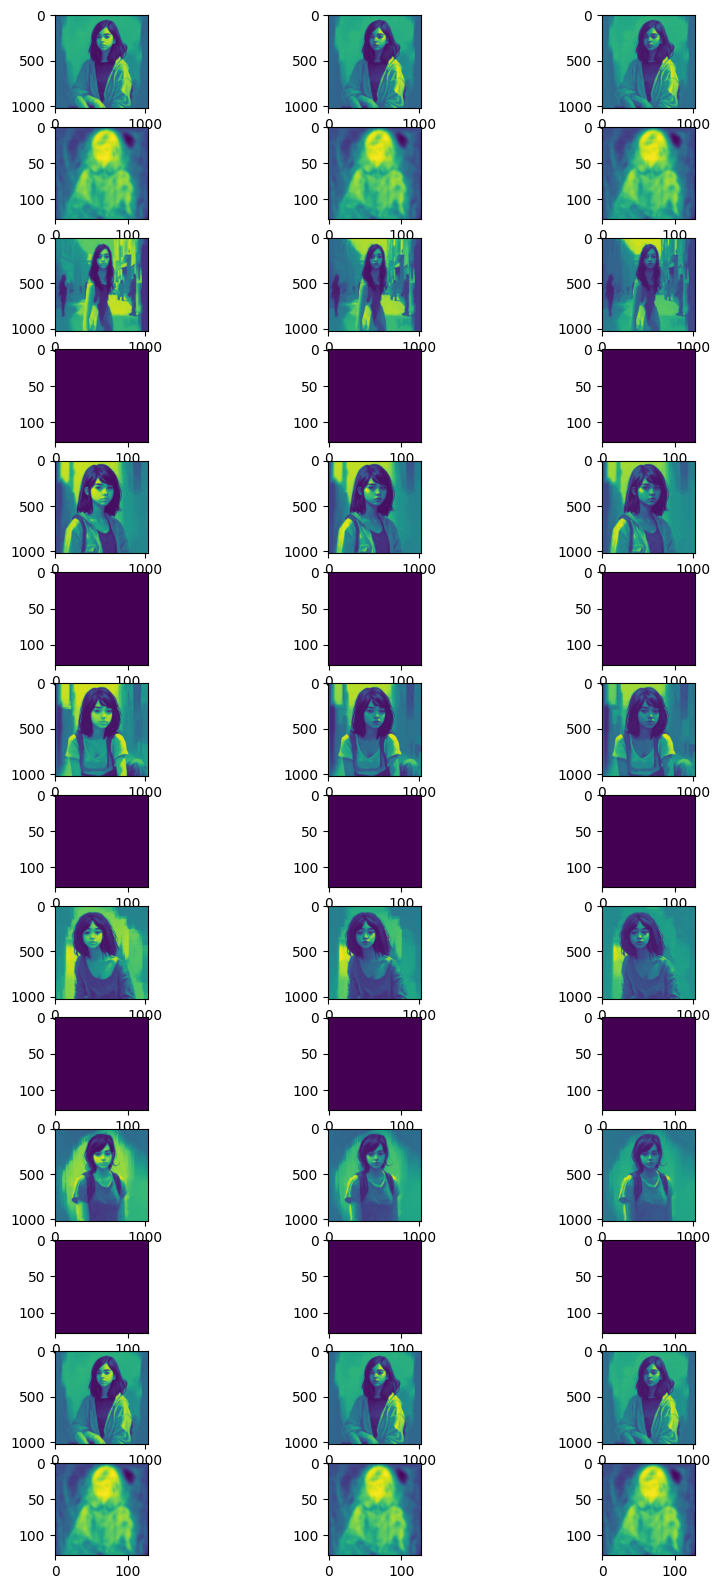

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import random

ds = train_dataset[random.randint(0, 100)]

f, axarr = plt.subplots(2 * len(ds['pixel_values']), 3, figsize=(10, 20))

for img_num in range(len(ds['pixel_values'])):
    for n in range(3):
        axarr[img_num * 2][n].imshow(ds['pixel_values'][img_num][n])
    for n in range(3):
        axarr[img_num * 2 + 1][n].imshow(ds['mask_pixel_values'][img_num][n])
plt.show()

In [13]:

    
    accelerator_project_config = ProjectConfiguration(project_dir=target_dir, logging_dir='logs')
    accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision="fp16",
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

/workspace/oa_venv/lib/python3.10/site-packages/accelerate/accelerator.py:401: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
set_seed(1000)

In [15]:
use_mask = True

In [16]:
    # Handle the repository creation
    now = datetime.now()
    train_id = now.strftime("%y%m%d%H%M") # uuid.uuid4()
    train_id = str(train_id)
    output_dir = f"{target_dir}/train_{train_id}"
    if accelerator.is_main_process:
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(f"{output_dir}/ckpt", exist_ok=True)
        os.makedirs(f"{output_dir}/weight", exist_ok=True)


In [17]:
    # Load Models
    pretrained_model_name_or_path = ENV_CONFIGS['paths']['sdxl_path']
    # Load the tokenizers
    tokenizer_one = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=None,
        use_fast=False,
    )
    tokenizer_two = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer_2",
        revision=None,
        use_fast=False,
    )

    # import correct text encoder classes
    text_encoder_cls_one = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path, None
    )
    text_encoder_cls_two = import_model_class_from_model_name_or_path(
        pretrained_model_name_or_path, None, subfolder="text_encoder_2"
    )

    # Load scheduler and models
    noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
    # Check for terminal SNR in combination with SNR Gamma
    text_encoder_one = text_encoder_cls_one.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder",
    )
    text_encoder_two = text_encoder_cls_two.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder_2",
    )

    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="vae",
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path, subfolder="unet",
    )
    
    # Freeze vae and text encoders.
    vae.requires_grad_(False)
    text_encoder_one.requires_grad_(False)
    text_encoder_two.requires_grad_(False)
    unet.requires_grad_(False)


/workspace/oa_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/workspace/Diploma/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (add_time_proj): Timesteps()
  (add_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=2816, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=1280, out_features=320, bias=True)
          (

In [18]:
    # Build projector
    projector = Projector(1280, 2048)
    # Fire projector
    projector.requires_grad_(True)



Projector(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1280, 640, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): Ba

In [19]:
unet.enable_xformers_memory_efficient_attention()
torch.backends.cuda.matmul.allow_tf32 = True

In [20]:
optimizer = torch.optim.AdamW(
        projector.parameters(),  # only optimize the embeddings
        lr=config['lr'],
        betas=(0.9, 0.999),
        weight_decay=1e-2,
        eps=1e-8,
    )

In [21]:
train_dataset = OneActorDataset(
        target_dir=target_dir,
        use_mask=use_mask,
        config=prompt,
        set='train',
    )

./experiments/2504301613_girl/target.jpg
['./experiments/2504301613_girl/base/img_1.jpg', './experiments/2504301613_girl/base/img_2.jpg', './experiments/2504301613_girl/base/img_3.jpg', './experiments/2504301613_girl/base/img_4.jpg', './experiments/2504301613_girl/base/img_5.jpg', './experiments/2504301613_girl/base/img_6.jpg', './experiments/2504301613_girl/base/img_7.jpg', './experiments/2504301613_girl/base/img_8.jpg', './experiments/2504301613_girl/base/img_9.jpg', './experiments/2504301613_girl/base/img_10.jpg', './experiments/2504301613_girl/base/img_11.jpg']


In [25]:
train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0
    )

In [26]:
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader))

max_train_steps = config['epochs'] * num_update_steps_per_epoch
overrode_max_train_steps = True

In [27]:
    lr_scheduler = get_scheduler(
        "constant",
        optimizer=optimizer,
        num_warmup_steps=500 * accelerator.num_processes,
        num_training_steps=max_train_steps * accelerator.num_processes,
        num_cycles=1,
    )

    projector.train()
    # Prepare everything with our `accelerator`.
    projector, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        projector, optimizer, train_dataloader, lr_scheduler
    )

    # For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
    # as these weights are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    # Move vae and unet to device and cast to weight_dtype

    with torch.cuda.amp.autocast(dtype=weight_dtype):
        unet.to(accelerator.device, dtype=weight_dtype)
        text_encoder_one.to(accelerator.device, dtype=weight_dtype)
        text_encoder_two.to(accelerator.device, dtype=weight_dtype)
    
    vae.to(accelerator.device, dtype=torch.float32)


In [28]:
    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader))
    if overrode_max_train_steps:
        max_train_steps = config['epochs'] * num_update_steps_per_epoch
    # Afterwards we recalculate our number of training epochs
    config['epochs'] = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("OneActor", config=config)

    # Train!
    total_batch_size = config['batch_size'] * accelerator.num_processes


In [29]:
    with open(f"{output_dir}/log_train.log", 'w') as log_file:
        print(f"num_examples: {len(train_dataset)}", file=log_file)
        print(f"num_epochs: {config['epochs']}", file=log_file)
        print(f"batch_size: {config['batch_size']}", file=log_file)
        print(f"total_batch_size: {total_batch_size}", file=log_file)
        print(f"max_train_steps: {max_train_steps}", file=log_file)
        print(f"target_dir: '{target_dir}'", file=log_file)
        print(f"train_id: '{train_id}'", file=log_file)
        print(f"use_mask: '{use_mask}'", file=log_file)
        # print(f"mask_power: '{mask_power}'", file=log_file)
        # print(f"mask_alpha: '{mask_alpha}'", file=log_file)

    run = init_wanddb(config={
        "thema":config['target_dir'],
        "exp_id":exp_id,
        "model_id":train_id,
        "use_mask":use_mask,
        # "mask_power":mask_power,
        # "mask_alpha":mask_alpha,
        "epoch":train_dataset.__len__(),
    })
# 16c91bc3767f14563f500e1342430f71c8b26518

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eadishcheva to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [30]:
    global_step = 0
    first_epoch = 0
    initial_global_step = 0

In [31]:
    progress_bar = tqdm(
        range(0, max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )
    
    best_loss = 1000.0


Steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [32]:
# from PIL import Image
# import matplotlib.pyplot as plt
# import random

# ds = train_dataset[random.randint(0, 100)]

# f, axarr = plt.subplots(2 * len(ds['pixel_values']), 3, figsize=(10, 20))

# for img_num in range(len(ds['pixel_values'])):
#     for n in range(3):
#         axarr[img_num * 2][n].imshow(ds['pixel_values'][img_num][n])
#     for n in range(3):
#         axarr[img_num * 2 + 1][n].imshow(ds['mask_pixel_values'][img_num][n])
# plt.show()

In [33]:
    mask_power = 0.5
    best_loss = 1000.0
    vae = vae.to(dtype=torch.float32)
            
    for epoch in range(first_epoch, config['epochs']):
        projector.train()
        train_loss = 0.0
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(projector):
   
                images = batch["pixel_values"][0].to(dtype=torch.float32)
                latents = vae.encode(images).latent_dist.sample().detach()                    
                latents.to(dtype=weight_dtype)
                latents = latents * vae.config.scaling_factor
                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                noise[-1] = noise[0]    # aver is the same as target
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()
                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                if use_mask:            
                    mask_latents = batch["mask_pixel_values"][0].to(dtype=weight_dtype)

                    noisy_mask_latents = ((1 - noise_scheduler.alphas_cumprod[timesteps.cpu()])**mask_power).view(bsz, 1, 1, 1).to(device)
                    noisy_mask_latents = noisy_mask_latents.to(device)
                    noisy_mask_latents = noisy_mask_latents \
                            + ((noise_scheduler.alphas_cumprod[timesteps.cpu()])**mask_power).view(bsz, 1, 1, 1).to(device) * mask_latents
    
                # time ids
                def compute_time_ids(original_size, crops_coords_top_left):
                    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
                    target_size = (1024, 1024)
                    add_time_ids = list(original_size + crops_coords_top_left + target_size)
                    add_time_ids = torch.tensor([add_time_ids])
                    with torch.cuda.amp.autocast(dtype=weight_dtype):
                        add_time_ids = add_time_ids.to(accelerator.device)
                    return add_time_ids # tensor(1, 6)
                
                original_size = (1024, 1024)
                crops_coords_top_left = (0, 0)
                add_time_ids = compute_time_ids(original_size, crops_coords_top_left).repeat(bsz, 1).to(accelerator.device)
                unet_added_conditions = {"time_ids": add_time_ids}
    
                text_encoders = [text_encoder_one, text_encoder_two]
                tokenizers = [tokenizer_one, tokenizer_two]
                # Get the text embedding for conditioning
                prompt_embeds_batch_list = []
                add_text_embeds_batch_list = []
                delta_emb = projector(batch['h_mid'][0, :, -1].to(device)) # torch.size(bs, 1280, 32, 32) -> torch.size(bs, 2048)
                delta_emb_aver = delta_emb[1:-1].mean(dim=0, keepdim=True)
                for b_s in range(bsz): # 1*target+n*base+1*aver
                    prompt = batch['text'][b_s][0] # str
                    prompt_embeds_list = []
    
                    first = 1
                    for tokenizer, text_encoder in zip(tokenizers, text_encoders):
    
                        text_inputs = tokenizer(
                            prompt,
                            padding="max_length",
                            max_length=tokenizer.model_max_length,
                            truncation=True,
                            return_tensors="pt",
                        )
                        tokens = tokenizer.encode(prompt)
                        
                        if first:
                            for i, token in enumerate(tokens):
                                if tokenizer.decode(token) == batch['base'][0]:
                                    base_token_id = i
                                    first = 0
                                    break
                        text_input_ids = text_inputs.input_ids
                        prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)
                        pooled_prompt_embeds = prompt_embeds[0]
                        prompt_embeds = prompt_embeds.hidden_states[-2]
                        prompt_embeds_list.append(prompt_embeds)
                    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)    # tensor(1, 77, 2048)
    
                    if b_s == bsz-1:
                        delta_emb_ = delta_emb_aver
                    else:
                        delta_emb_ = delta_emb[b_s:b_s+1]
                    prompt_embeds[:, base_token_id, :] = prompt_embeds[:, base_token_id, :] + delta_emb_

                    prompt_embeds_batch_list.append(prompt_embeds)
                    add_text_embeds_batch_list.append(pooled_prompt_embeds)
                
                prompt_embeds = torch.concat(prompt_embeds_batch_list, dim=0)
                add_text_embeds = torch.concat(add_text_embeds_batch_list, dim=0).to(accelerator.device)
    
                unet_added_conditions.update({"text_embeds": add_text_embeds})
                prompt_embeds = prompt_embeds.to(accelerator.device)
    
    
                # Predict the noise residual
                dtype = unet.dtype

                noisy_latents = noisy_latents.to(dtype)
                prompt_embeds = prompt_embeds.to(dtype)
                timesteps = timesteps.to(dtype)
                unet_added_conditions["text_embeds"] = unet_added_conditions["text_embeds"].to(dtype)
                unet_added_conditions["time_ids"] = unet_added_conditions["time_ids"].to(dtype)

                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=prompt_embeds, added_cond_kwargs=unet_added_conditions).sample
    
    
                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if use_mask:
                    loss_target = F.mse_loss(model_pred[:1].float() * noisy_mask_latents[:1].float(),
                                             target[:1].float() * noisy_mask_latents[:1].float(), reduction="mean")
                    loss_base = F.mse_loss(model_pred[1:-1].float() * noisy_mask_latents[1:-1].float(),
                                             target[1:-1].float() * noisy_mask_latents[1:-1].float(), reduction="mean")
                    loss_aver = F.mse_loss(model_pred[-1:].float() * noisy_mask_latents[-1:].float(),
                                             target[-1:].float() * noisy_mask_latents[-1:].float(), reduction="mean")
                else:
                    loss_target = F.mse_loss(model_pred[:1].float(),
                                             target[:1].float(), reduction="mean")
                    loss_base = F.mse_loss(model_pred[1:-1].float(),
                                             target[1:-1].float(), reduction="mean")
                    loss_aver = F.mse_loss(model_pred[-1:].float(),
                                             target[-1:].float(), reduction="mean")
                    
                loss = loss_target + config['lambda1'] * loss_base + config['lambda2'] * loss_aver    
                avg_loss = accelerator.gather(loss.repeat(config['batch_size'])).mean()
                train_loss += avg_loss.item()

                run.log({"loss": loss})


                accelerator.backward(loss)
    
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % config['save_steps'] == 0:
                    weight_name = (
                        f"learned-projector-steps-{global_step}.pth"
                    )
                    save_path = os.path.join(output_dir, 'weight', weight_name)

                    save_progress(
                        projector,
                        accelerator,
                        save_path,
                    )
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    best_step = initial_global_step + global_step
                    print(f'Best loss:{best_loss} @@@ Step:{best_step}')
                    weight_name = (
                        f"best-learned-projector.pth"
                    )
                    save_path = os.path.join(output_dir, 'weight', weight_name)

                    save_progress(
                        projector,
                        accelerator,
                        save_path,
                    )

                if accelerator.is_main_process:
                    if global_step % config['checkpointing_steps'] == 0:
                        save_path = os.path.join(output_dir, 'ckpt', f"checkpoint-{initial_global_step + global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {"loss": train_loss, "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            train_loss = 0.0

    # Create the pipeline using the trained modules and save it.
    accelerator.wait_for_everyone()
   
    print(f'Best loss:{best_loss} @@@ Step:{best_step}')
    accelerator.end_training()
    # Finish the run and upload any remaining data.
    run.finish()


/workspace/oa_venv/lib/python3.10/site-packages/diffusers/models/lora.py:228: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(
/workspace/oa_venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Steps:   0%|          | 1/200 [00:13<44:31, 13.42s/it]04/29/2025 20:18:14 - INFO - __main__ - Saving embeddings


Best loss:0.1687372624874115 @@@ Step:1


Steps:   2%|▏         | 3/200 [00:23<22:14,  6.77s/it, loss=0.215, lr=0.0001]04/29/2025 20:18:24 - INFO - __main__ - Saving embeddings


Best loss:0.14465458691120148 @@@ Step:3


Steps:   4%|▍         | 9/200 [00:50<15:04,  4.74s/it, loss=0.344, lr=0.0001]04/29/2025 20:18:52 - INFO - __main__ - Saving embeddings


Best loss:0.11338549852371216 @@@ Step:9


Steps:  10%|▉         | 19/200 [01:39<13:52,  4.60s/it, loss=0.124, lr=0.0001]04/29/2025 20:19:40 - INFO - __main__ - Saving embeddings


Best loss:0.10834071040153503 @@@ Step:19


Steps:  18%|█▊        | 37/200 [03:02<12:29,  4.60s/it, loss=0.355, lr=0.0001]04/29/2025 20:21:04 - INFO - __main__ - Saving embeddings


Best loss:0.06241400167346001 @@@ Step:37


Steps: 100%|██████████| 200/200 [15:29<00:00,  4.47s/it, loss=0.415, lr=0.0001]

Best loss:0.06241400167346001 @@@ Step:37


loss,▇▂▂▇▄▂▃▃▁█▂▆▂▅▇▇▅▅▄▃▄▂▅▅▆▃▂▂▃▅▇▃▅▆▆▅▄▆▂▅
loss,0.41545
